### Pose Estimation for Biomechanics - Credits: Mobilize Center Stanford University

Quantitative motion analysis is important for the diagnostics of movement disorders and for research. State-of-the-art measurements involve optical motion capture using reflective markers and expensive cameras to capture trajectories of these markers. Though the technique provides high frequency data for assessment, the cost, skills, and time involved limit wide adoption.

Recent advancements in deep learning allow us to very robustly detect body landmarks (such as toes, hips, shoulders, etc.) in images from commodity cameras, such as found in smartphones. We can apply these techniques to videos to derive trajectories of landmarks in time. Recent studies show that these trajectories can be used for some clinical applications, potentially reducing the cost of movement analyses by orders of magnitude and facilitating more frequent assessments.

##Tutorial Overview
**In this notebook we illustrate how to use one deep learning algorithm to analyze human motion. Specifically, we will extract knee flexion curves and gait cycles from a video of a subject walking.** The notebook is for illustrative purposes only, and multiple improvements should be incorporated to obtain accurate knee flexion angles. However, the notebook does provide a pipeline that you can adapt to get started with video-based pose estimation projects.

## Mediapipe installation

This will take a while

In [8]:
!pip install numpy==1.19.3
!pip install mediapipe

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached numpy-1.19.3.zip (7.3 MB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  error: subprocess-exited-with-error
  
  × Building wheel for numpy (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for numpy
Failed to build numpy
ERROR: Could not build wheels for numpy, which is required to install pyproject.toml-based projects
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Vizualization utilities

In [2]:
from mediapipe import solutions
from mediapipe.framework.formats import landmark_pb2
import numpy as np
import cv2
import mediapipe as mp
from google.colab.patches import cv2_imshow
mp_drawing = mp.solutions.drawing_utils
mp_pose = mp.solutions.pose


def draw_landmarks_on_image(rgb_image, detection_result):
  pose_landmarks_list = detection_result.pose_landmarks
  annotated_image = np.copy(rgb_image)

  # Loop through the detected poses to visualize.
  for idx in range(len(pose_landmarks_list)):
    pose_landmarks = pose_landmarks_list[idx]

    # Draw the pose landmarks.
    pose_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
    pose_landmarks_proto.landmark.extend([
      landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in pose_landmarks
    ])
    solutions.drawing_utils.draw_landmarks(
      annotated_image,
      pose_landmarks_proto,
      solutions.pose.POSE_CONNECTIONS,
      solutions.drawing_styles.get_default_pose_landmarks_style())
  return annotated_image

Upload any image that you want to use to extrect the pose. You can upload it in two ways. 
- You can run the cell below and upload the image you want
- Click the Files folder icon fileFolderIcon.jpg in the left-hand column to see the current files in your virtual Colab environment and upload the file you want to analyze.

In [ ]:
from google.colab import files

uploaded = files.upload()

violin


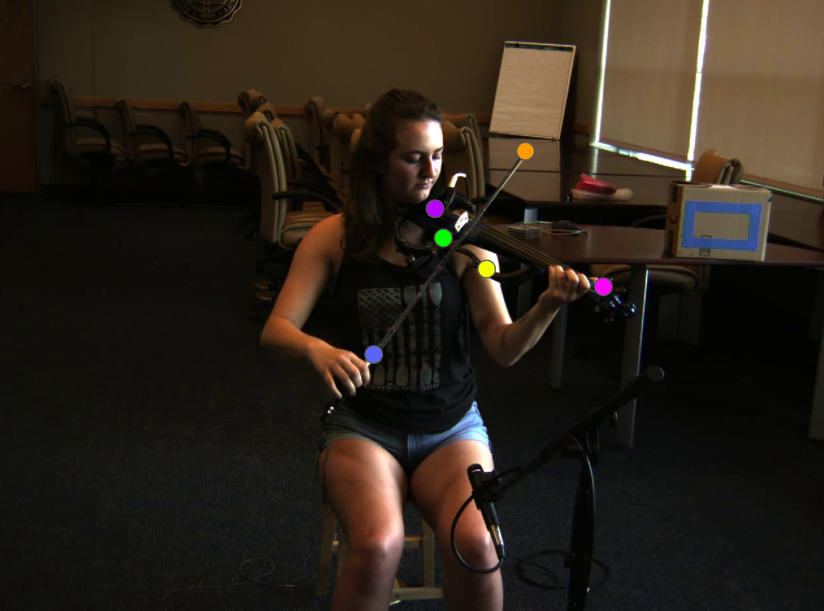

In [9]:
# Read images with OpenCV by uncommented the line you should use.
#images = {name: cv2.imread(name) for name in uploaded.keys()}
images = {'violin': cv2.imread('hyp_points.png')} #change the name of the image here!!!!!!!!!!!

# Preview the images.
for name, image in images.items():
  print(name)   
  cv2_imshow(image)

All MediaPipe Solutions Python API examples are under mp.solutions.

For the MediaPipe Pose solution, we can access this module as `mp_pose = mp.solutions.pose`.

You may change the parameters, such as `static_image_mode` and `min_detection_confidence`, during the initialization. Run `help(mp_pose.Pose)` to get more informations about the parameters and select those more appropriate for the example you selected.

In [10]:
mp_pose = mp.solutions.pose

help(mp_pose.Pose)

# Initialize MediaPipe Pose.
pose = mp_pose.Pose(
    static_image_mode=True, min_detection_confidence=0.5)

Help on class Pose in module mediapipe.python.solutions.pose:

class Pose(mediapipe.python.solution_base.SolutionBase)
 |  Pose(static_image_mode=False, model_complexity=1, smooth_landmarks=True, enable_segmentation=False, smooth_segmentation=True, min_detection_confidence=0.5, min_tracking_confidence=0.5)
 |  
 |  MediaPipe Pose.
 |  
 |  MediaPipe Pose processes an RGB image and returns pose landmarks on the most
 |  prominent person detected.
 |  
 |  Please refer to https://solutions.mediapipe.dev/pose#python-solution-api for
 |  usage examples.
 |  
 |  Method resolution order:
 |      Pose
 |      mediapipe.python.solution_base.SolutionBase
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, static_image_mode=False, model_complexity=1, smooth_landmarks=True, enable_segmentation=False, smooth_segmentation=True, min_detection_confidence=0.5, min_tracking_confidence=0.5)
 |      Initializes a MediaPipe Pose object.
 |      
 |      Args:
 |        static_i

In [11]:
# Prepare DrawingSpec for drawing the face landmarks later.
mp_drawing = mp.solutions.drawing_utils 
drawing_spec = mp_drawing.DrawingSpec(thickness=2, circle_radius=2)

Nose coordinates: (425.3913869857788, 173.08538201451302)
Pose landmarks of violin:


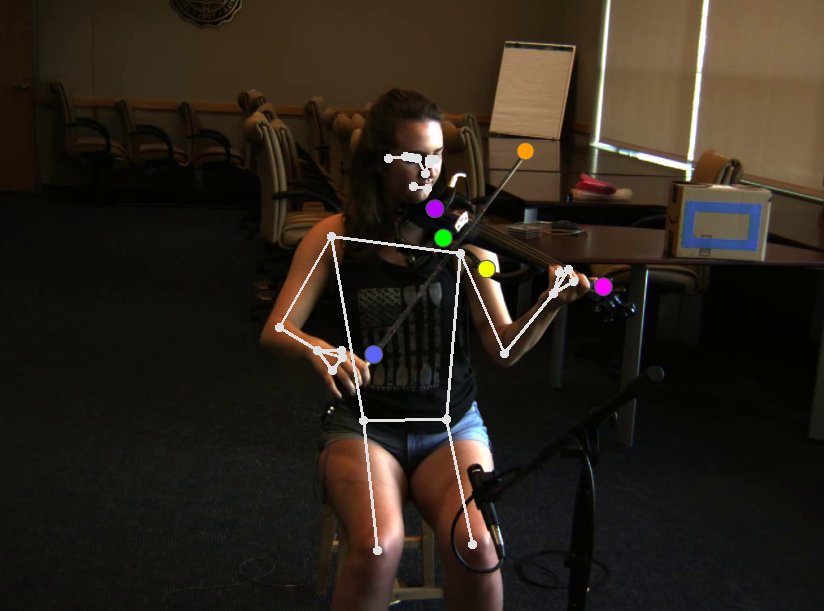

In [12]:
for name, image in images.items():
  # Convert the BGR image to RGB and process it with MediaPipe Pose.
  results = pose.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
  # Print nose landmark.
  image_hight, image_width, _ = image.shape
  if not results.pose_landmarks:
    continue
  print(
    f'Nose coordinates: ('
    f'{results.pose_landmarks.landmark[mp_pose.PoseLandmark.NOSE].x * image_width}, '
    f'{results.pose_landmarks.landmark[mp_pose.PoseLandmark.NOSE].y * image_hight})'
  )

  # Draw pose landmarks.
  print(f'Pose landmarks of {name}:')
  annotated_image = image.copy()
  mp_drawing.draw_landmarks(
      image=annotated_image,
      landmark_list=results.pose_landmarks,
      connections=mp_pose.POSE_CONNECTIONS,
      landmark_drawing_spec=drawing_spec,
      connection_drawing_spec=drawing_spec)
  cv2_imshow(annotated_image)

## Try different images and try to find an image where it is difficult to find the pose (occlusions , strange poses ...) and comment a bit the results!!

### Let's now analyze videos. 

Upload a video: click the Files folder icon fileFolderIcon.jpg in the left-hand column to see the current files in your virtual Colab environment and upload the file you want to analyze or use your webcam.

Here there are the keypoints extracted with Mediapipe - Pose

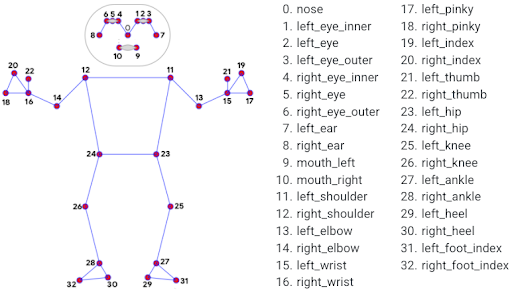

In [13]:
NOSE = 0
LEYE_IN = 1
LEYE = 2
LEYE_OUT = 3
REYE_IN = 4
REYE = 5
REYE_OUT = 6
LEAR = 7
REAR = 8
LMOUTH = 9
RMOUTH = 10
LSH = 11
RSH = 12
LELB = 13
RELB = 14
LWR = 15
RWR = 16
LPK = 17
RPK = 18
LIND = 19
RIND = 20
LTH = 21
RTH = 22
LHIP = 23
RHIP = 24
LKNE = 25
RKNE = 26
LANKL = 27
RANKL = 28
LHEEL = 29
RHEEL = 30
LFOOT = 31
RFOOT = 32

print("DONE: Short keywords assigned")

DONE: Short keywords assigned


##Function to calculate angles

Calculate angles between different points and think if they are reasonable or not. Save the angles in a list and plot them.

In [14]:
def calculate_angle(a,b,c):
    a = np.array(a) # First
    b = np.array(b) # Mid
    c = np.array(c) # End
    
    radians = np.arctan2(c[1]-b[1], c[0]-b[0]) - np.arctan2(a[1]-b[1], a[0]-b[0])
    angle = np.abs(radians*180.0/np.pi)
    
    if angle >180.0:
        angle = 360-angle
        
    return angle 

In [15]:
cap = cv2.VideoCapture('cam0#030.avi')
width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)) 
size = (width,height)
inx = 0
angles_tot = []
out = cv2.VideoWriter('output.avi',cv2.VideoWriter_fourcc(*'DIVX'), 30, size)
## Setup mediapipe instance
with mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
    while cap.isOpened():
        ret, frame = cap.read()
        #print(str(inx))
        # Recolor image to RGB
        if ret == False:
          blank_image = np.zeros((height,width,3), np.uint8)
          image = cv2.cvtColor(blank_image, cv2.COLOR_BGR2RGB)
          break
        else:
          image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        
          image.flags.writeable = False
        
          # Make detection
          results = pose.process(image)
      
          # Recolor back to BGR
          image.flags.writeable = True
          image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
          
          # Extract landmarks
          try:
              landmarks = results.pose_landmarks.landmark
              
              # Get coordinates
              shoulder = [landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER.value].x,landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER.value].y]
              elbow = [landmarks[mp_pose.PoseLandmark.RIGHT_ELBOW.value].x,landmarks[mp_pose.PoseLandmark.RIGHT_ELBOW.value].y]
              wrist = [landmarks[mp_pose.PoseLandmark.RIGHT_WRIST.value].x,landmarks[mp_pose.PoseLandmark.RIGHT_WRIST.value].y]
              
              # Calculate angle
              angle = calculate_angle(shoulder, elbow, wrist)
              
              # Visualize angle
              cv2.putText(image, str(angle), 
                            tuple(np.multiply(elbow, [640, 480]).astype(int)), 
                            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2, cv2.LINE_AA
                                  )
              angles_tot.append(angle)
                        
          except:
              pass
          
          
          # Render detections
          mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS,
                                mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=2), 
                                mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2) 
                                 )               
        
        out.write(image)
        inx = inx + 1
        #cv2_imshow(image)


        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()

In [16]:
print(angles_tot)

[100.91976844372583, 102.07587177339165, 102.31769519794192, 102.478184474976, 102.60773735513204, 102.48853460450029, 101.91021345263145, 101.21171202819222, 99.64705173928554, 96.74956725211514, 90.83774966357856, 86.0857357397263, 81.62669787731538, 75.5683551199395, 68.09448973291101, 60.976119295621764, 55.29598757901387, 48.78129463829102, 43.95570872059387, 39.8768340503091, 36.68776752404649, 32.61314242384894, 28.860135572961084, 27.418324608323136, 25.445591115864875, 26.02135314901508, 25.07315820811212, 23.181333317903288, 23.848267894467572, 23.99381232449569, 24.15750810413004, 25.05818439753932, 25.808833685691486, 26.20974267739932, 27.114927981841028, 26.82423475224429, 27.26690709272799, 28.256401094652738, 28.595885594610486, 28.855373630618008, 28.713498192344098, 28.417550260912645, 28.11349263776009, 27.47728458038902, 26.8895945431149, 26.67919406522457, 26.688185258659203, 26.755566436189014, 26.449350704415462, 26.479262474459354, 26.558936545653097, 26.6086997

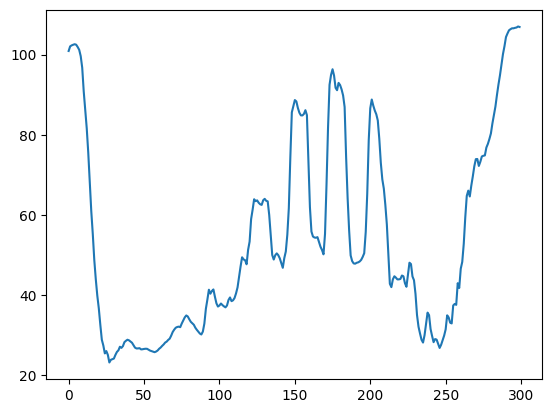

In [17]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(angles_tot)
plt.show()

##TODO
For instace it is possible to use the video of you walking or doing sport and try to compute the angle at the knee